In [1]:
!pwd

/home/yiyi/Documents/computerlinguistik-master/ss2019/semantik2/project/cdl


In [2]:
pred_arg_types_binary= '/home/yiyi/Documents/computerlinguistik-master/ss2019/semantik2/project/data/pred_arg_types_binary.json'


In [3]:
import json
import numpy as np
from collections import defaultdict, Counter
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [4]:
def extract_all_argument_pairs(pred_arg_types_binary):
    with open(pred_arg_types_binary) as fp:
        pred_arg_types_binary_dict= json.load(fp)
        
    pred_arg_types_dict={}    # for each pred, {(loc, pers):[(mc,ls),(us, luis)...]}
    
    pred_args_dict=defaultdict(list) # {'star':[(mc,ls),(us,luis)...]}
    pred_arg_types_distribution={}
    
    arg_all=[]
    type_all=[]
    arg_pairs_all=[]
    type_pairs_all=[]
    for pred, args_dict in pred_arg_types_binary_dict.items():
        type_arg_dict=defaultdict(list)
        arg_pairs=[]
        type_pairs=[]
        for line  in args_dict:
            arg_pair=[]
            types=[]
            
            for index, words_type in sorted(line.items()):
                word, type= words_type
                types.append(type)
                type_all.append(type)
                arg_pair.append(word.lower())
                arg_all.append(word.lower())
            if len(arg_pair)==2:
                arg_pairs.append(tuple(arg_pair))
                type_pairs.append(tuple(types))
                
            if len(arg_pair)==3:
                arg_pairs.append(tuple((arg_pair[0], arg_pair[1])))
                arg_pairs.append(tuple((arg_pair[0], arg_pair[2])))
                type_pairs.append(tuple((types[0], types[1])))
                type_pairs.append(tuple((types[0], types[2])))
            
            if len(arg_pair)==4:
                arg_pairs.append(tuple((arg_pair[0], arg_pair[1])))
                arg_pairs.append(tuple((arg_pair[0], arg_pair[2])))
                arg_pairs.append(tuple((arg_pair[0], arg_pair[3])))
                type_pairs.append(tuple((types[0], types[1])))
                type_pairs.append(tuple((types[0], types[2])))
                type_pairs.append(tuple((types[0], types[3])))
                
        pred_args_dict[pred].extend(arg_pairs)
        
        arg_pairs_all.extend(arg_pairs)
        type_pairs_all.extend(type_pairs)
        
        first_types=[type_pair[0] for type_pair in type_pairs]
        second_types=[type_pair[1] for type_pair in type_pairs]
        
        first_types_counter= Counter(first_types)
        second_types_counter = Counter(second_types)
        pred_arg_types_distribution[pred]={
            'arg0_type':{type_:freq/len(first_types) for type_, freq in first_types_counter.items() },
            'arg1_type':{type_:freq/len(second_types) for type_, freq in second_types_counter.items() }
        }
        
        
        for idx, type_pair in enumerate(type_pairs):
            type_arg_dict[type_pair].append(arg_pairs[idx])
        
        pred_arg_types_dict[pred]=type_arg_dict
    
    pred_type_arg_freq={}
    for pred, type_arg_dict in pred_arg_types_dict.items():
        types_arg_counter={}
        for type_, args in type_arg_dict.items():
            types_arg_counter[type_]=Counter(args)
        pred_type_arg_freq[pred]= types_arg_counter
    return arg_pairs_all, type_pairs_all, arg_all, type_all,  pred_type_arg_freq, pred_arg_types_distribution, pred_args_dict

In [5]:
arg_pairs, type_pairs,arg_all, type_all, pred_arg_types_dict, pred_arg_types_distribution, pred_args_dict = extract_all_argument_pairs(pred_arg_types_binary)
unique_arg_pairs=list(set(arg_pairs))
len(unique_arg_pairs),len(arg_pairs), len(set(type_pairs)), len(pred_arg_types_dict), len(pred_args_dict['star'])

(14859, 15442, 16, 1418, 50)

In [ ]:
pred_arg_types_dict

In [ ]:
arg_types_dict=defaultdict(list)
for arg, type_ in zip(arg_all, type_all):
    arg_types_dict[arg].append(type_)
    
# arg_type_dict={ arg: type_ for arg, type_ in zip(arg_all, type_all)}
# arg_type_dict

In [ ]:
arg_types_prob_dict={}
for arg, types in arg_types_dict.items():
    type_dict=Counter(types)
    total = len(types)
    prob_dict={key:float("{0:.2f}".format(value/total)) for key, value in type_dict.items()}
    arg_types_prob_dict[arg]= prob_dict
    
arg_types_prob_dict

In [9]:
len(arg_types_prob_dict)

15780

In [7]:
# pred_arg_types_distribution

In [11]:
args2id= {pair:idx for idx, pair in enumerate(unique_arg_pairs)}
id2args={idx:pair for idx, pair in enumerate(unique_arg_pairs)}
len(args2id)

14859

In [9]:
predicates=pred_arg_types_dict.keys()
len(predicates)

1418

In [10]:
ls=[0 for i in range(len(args2id))]

In [11]:
len(ls)

14859

In [ ]:
# arg_type_dict={arg:type}
# vectors with augmentation
vector_dict={}
for pred, type_pair_dict in pred_arg_types_dict.items():
    type_vector_dict={}
    print(pred)
    ## if applied 
    arg_type_distribution_dict=pred_arg_types_distribution[pred]
    print(type_pair_dict)

    for type_pair, arg_counter in type_pair_dict.items():
        vector_list=[0 for i in range(len(args2id))]
        type0, type1 = type_pair
        # initialization with the predictions
        for idx, args in id2args.items():
            arg0, arg1 = args
            prob_dict0, prob_dict1= arg_types_prob_dict[arg0], arg_types_prob_dict[arg1]
            joint_distribution = prob_dict0.get(type0,0)* prob_dict1.get(type1,0)
            vector_list[idx] = joint_distribution
            # print(prob_dict0, prob_dict1)
            # type1, type2 = arg_type_dict[arg0], arg_type_dict[arg1]
            
#             type1_prob = arg_type_distribution_dict['arg0_type'].get(type0,0)
#             type2_prob = arg_type_distribution_dict['arg1_type'].get(type1,0)
#             vector_list[idx]=  type1_prob* type2_prob+ joint_distribution

        
        # which has the arg_pair in typed_predicate
        for arg_pair, freq in arg_counter.items():            
            vector_list[args2id[arg_pair]] += freq 
            
        # type_vector_dict[type_pair]=np.asarray(vector_list)
        pred_type_pair=pred+'-'+type_pair[0]+'-'+type_pair[1]
        vector_dict[pred_type_pair]= np.asarray(vector_list)
        

In [13]:
len(vector_dict.keys())

4560

In [ ]:
vector_dict

In [36]:
# without augmentation
vector_pred={}
for pred, arg_pair_list in pred_args_dict.items():
    vector_list=[0 for i in range(len(args2id))]
    for arg_pair in arg_pair_list:
        vector_list[args2id[arg_pair]]+=1
    vector_pred[pred]=np.asarray(vector_list)

In [20]:
keys_pred= []
matrix_pred= []
for key, vector in vector_pred.items():
    keys_pred.append(key)
    matrix_pred.append(vector)

In [21]:
features_pred = np.vstack(matrix_pred)
features_pred.shape

(1418, 14859)

In [22]:
label2id_pred={label:idx for idx, label in enumerate(keys_pred)}
id2label_pred={idx:label for idx, label in enumerate(keys_pred)}
labels_pred= np.array(keys_pred)
labels_pred.shape

(1418,)

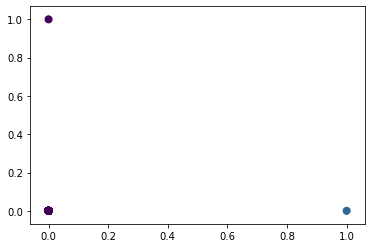

In [23]:
from sklearn.cluster import KMeans
from scipy import sparse

kmeans_pred= KMeans(n_clusters=4)
kmeans_pred.fit(features_pred)
y_kmeans_pred= kmeans_pred.predict(features_pred)
plt.scatter(features_pred[:, 0], features_pred[:, 1],  c=y_kmeans_pred, s=50, cmap='viridis')

In [43]:
# augmented data
keys= []
matrix= []
for key, vector in vector_dict.items():
    keys.append(key)
    matrix.append(vector)
    

In [38]:
features=np.vstack(matrix)
features.shape

(4560, 14859)

In [39]:
label2id={label:idx for idx, label in enumerate(keys)}
id2label={idx:label for idx, label in enumerate(keys)}

In [40]:
labels=np.asarray(keys)
labels.shape

(4560,)

In [24]:
df=df.rename(index= {0:"write_{arg0:PER,arg1:Book}",1:"suggest_{arg0:ORG, arg1:LOC}",2:"suggest_{arg0:PER, arg1:PER}"})


In [53]:
from sklearn.cluster import KMeans
from scipy import sparse

kmeans= KMeans(n_clusters=4)
kmeans.fit(features)
y_kmeans= kmeans.predict(features)


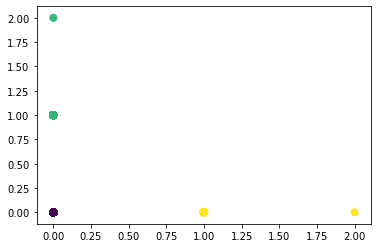

In [54]:
plt.scatter(features[:, 0], features[:, 1],  c=y_kmeans, s=50, cmap='viridis')

In [27]:
id2args

{0: ('harrison', 'john lennon'),
 1: ('german', 'languages of the european union'),
 2: ('j. m. coetzee', 'waiting for the barbarians'),
 3: ('finland', 'finland'),
 4: ('hypercard', 'violawww'),
 5: ('owendo', 'booué'),
 6: ('shimon peres', 'kadima'),
 7: ('john galt', 'atlas shrugged'),
 8: ('cpr', 'budd rail diesel cars'),
 9: ('brazil', 'renault'),
 10: ('jehosaphat', 'asa'),
 11: ('turku', 'finnish language'),
 12: ('soyuz rocket', 'french guiana'),
 13: ('euromonitor international', 'artistry'),
 14: ('dc', 'the spirit'),
 15: ('roger bacon', 'hebrew'),
 16: ('artemis', 'apollo'),
 17: ('audi', 'new york yankees'),
 18: ('european union', 'hungary'),
 19: ('kraków', 'roman catholic church'),
 20: ('dayton', 'united states'),
 21: ('european economic community', 'eu'),
 22: ('f-14', 'u.s. navy'),
 23: ('eighth avenue', 'broadway'),
 24: ('mamet', 'israel'),
 25: ('hurst', 'argentina'),
 26: ('davis', 'garfield'),
 27: ('palácio do planalto', 'brasília'),
 28: ('nhs scotland', 'abe

In [58]:
features_df = pd.DataFrame(features)
features_df = features_df.rename(columns= id2args)
features_df = features_df.rename(index= id2label)
features_df.head()

,"(boc tower, hong kong)","(chaplin, chaplin)","(walter gropius, bauhaus)","(hawaii state supreme court, ali ʻ iōlani hale)","(thurgot, saint andrews)","(santiniketan, indian)","(goldwater, reagan)","(dostum, rabbani)","(coloman, béla)","(rockies, oakland athletics)",...,"(bali strait, java)","(brown, sarah macaulay)","(statenvertaling, dutch)","(sagan, aaas 's)","(spain, coimbra)","(france, cascade mountains)","(love, brian wilson)","(lenin, reds)","(kelly, daisy bell)","(mclean, lisa kindred)"
star-PER-MISC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,1.0,0.0
star-PER-PER,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.38,0.0,0.0,0.0,0.0,0.78,0.0,0.0,1.0
star-ORG-PER,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.62,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
star-MISC-MISC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,1.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
star-MISC-PER,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.22,0.0,0.0,0.0


In [ ]:
features_df.describe()

### Augmented data

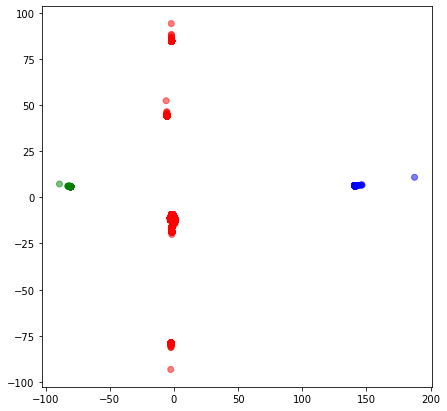

In [42]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(features)


pca = PCA(n_components=16)
x_7d = pca.fit_transform(X)

pca4 = PCA(n_components=4)
x_4d = pca.fit_transform(X)

#Set a 3 KMeans clustering
kmeans = KMeans(n_clusters = 3)

#Compute cluster centers and predict cluster indices
X_clustered = kmeans.fit_predict(x_7d)

#Define our own color map
LABEL_COLOR_MAP = {0:'r', 1: 'g', 2: 'b'}
label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]

# Plot the scatter digram
plt.figure(figsize = (7,7))
plt.scatter(x_7d[:,0],x_7d[:,3], c= label_color, alpha=0.5, cmap='viridis') 
plt.show()

In [45]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(features_df)

pca4 = PCA(n_components=16)
x_4d = pca.fit_transform(X)

#Set a 3 KMeans clustering
kmeans = KMeans(n_clusters = 4)

X_clustered= kmeans.fit(x_4d)
cluster_map = pd.DataFrame()
cluster_map['data_index']=features_df.index.values
cluster_map['cluster']=X_clustered.labels_

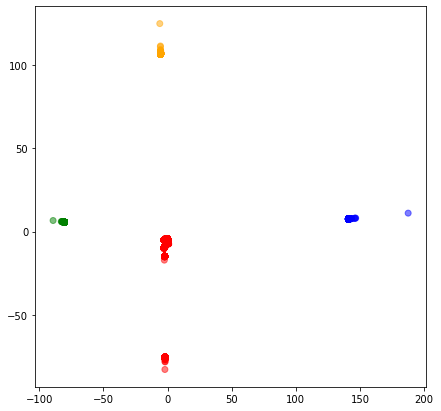

In [46]:

X = StandardScaler().fit_transform(features_df)

pca4 = PCA(n_components=16)
x_4d = pca.fit_transform(X)

#Set a 3 KMeans clustering
kmeans = KMeans(n_clusters = 4)

#Define our own color map
X_clustered = kmeans.fit_predict(x_4d)
LABEL_COLOR_MAP = {0:'r', 1: 'g', 2: 'b', 3:'orange'}
label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]

# Plot the scatter digram
plt.figure(figsize = (7,7))
plt.scatter(x_4d[:,0],x_4d[:,2],c= label_color, alpha=0.5, cmap='viridis') 
plt.show()



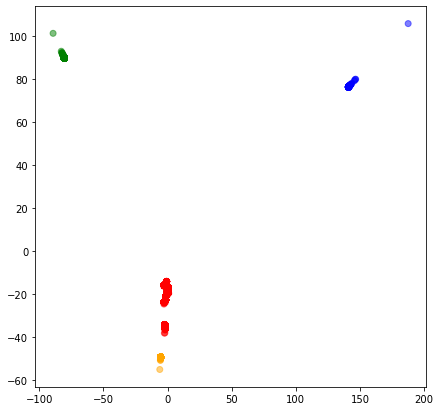

In [48]:
plt.figure(figsize = (7,7))
plt.scatter(x_4d[:,0],x_4d[:,1],c= label_color, alpha=0.5, cmap='viridis') 
plt.show()


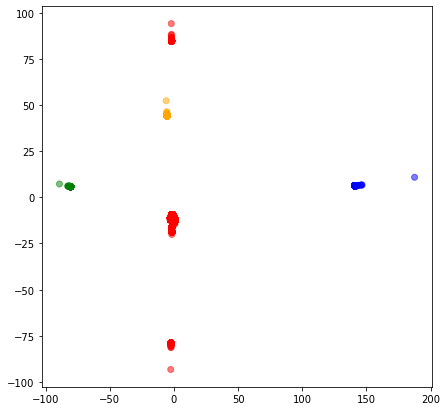

In [49]:
plt.figure(figsize = (7,7))
plt.scatter(x_4d[:,0],x_4d[:,3],c= label_color, alpha=0.5, cmap='viridis') 
plt.show()


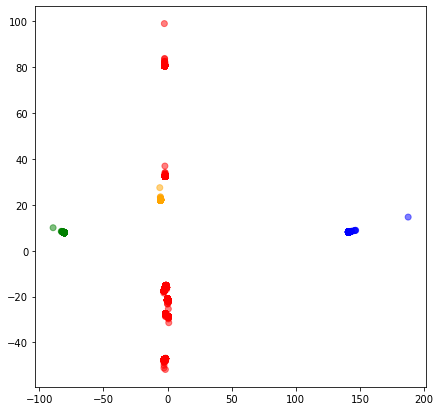

In [50]:
plt.figure(figsize = (7,7))
plt.scatter(x_4d[:,0],x_4d[:,4],c= label_color, alpha=0.5, cmap='viridis') 
plt.show()


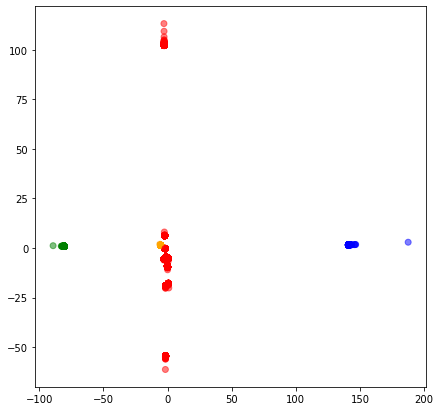

In [51]:
plt.figure(figsize = (7,7))
plt.scatter(x_4d[:,0],x_4d[:,5],c= label_color, alpha=0.5, cmap='viridis') 
plt.show()


In [82]:
x_4d.shape

(4560, 16)

In [47]:
for i in range(0, 4):
    print(cluster_map[cluster_map.cluster==i])

                 data_index  cluster
16               be-LOC-LOC        0
35      established-LOC-LOC        0
48            carry-LOC-LOC        0
70             give-LOC-LOC        0
74             hold-LOC-LOC        0
93             have-LOC-LOC        0
106         consist-LOC-LOC        0
121            play-LOC-LOC        0
129          remain-LOC-LOC        0
145            lose-LOC-LOC        0
161            beat-LOC-LOC        0
165           clash-LOC-LOC        0
173       establish-LOC-LOC        0
185           leave-LOC-LOC        0
196     incorporate-LOC-LOC        0
213            lead-LOC-LOC        0
233           write-LOC-LOC        0
244           serve-LOC-LOC        0
300          follow-LOC-LOC        0
315           offer-LOC-LOC        0
322        separate-LOC-LOC        0
331          manage-LOC-LOC        0
335           cause-LOC-LOC        0
341            link-LOC-LOC        0
348          become-LOC-LOC        0
365         provide-LOC-LOC        0
3

## analysis explained variance measure

In [39]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(features)

In [40]:
X.shape

(4560, 14859)

In [41]:
mean_vec= np.mean(X, axis=0)
cov_mat= np.cov(X.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

In [42]:
eig_vals.shape

(14859,)

In [43]:
eig_vecs.shape

(14859, 14859)

In [57]:
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

#sort from high to low
eig_pairs.sort(key=lambda  x:x[0], reverse=True)
tot= sum(eig_vals)
var_exp=[(i/tot)*100  for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp) # cumulative explained variance
var_exp

[(21.779132429600566+0j),
 (15.23378444502121+0j),
 (10.930851789580757+0j),
 (9.690065648808035+0j),
 (8.190966799578705+0j),
 (5.761317686462058+0j),
 (4.381647145256029+0j),
 (4.173206437347235+0j),
 (3.826808281415417+0j),
 (3.428680507056521+0j),
 (3.0524210924015756+0j),
 (2.6247075354640477+0j),
 (2.104967618545094+0j),
 (1.6967483466787159+0j),
 (1.6011670899345312+0j),
 (0.040378155756904004+0j),
 (0.039448444342027635+0j),
 (0.018367745696577623+0j),
 (0.01736506213226367+0j),
 (0.015850100739687956+0j),
 (0.014694563134223416+0j),
 (0.013507156299660266+0j),
 (0.013157879913510036+0j),
 (0.012984813150927844+0j),
 (0.011658991186187791+0j),
 (0.010598790049112931+0j),
 (0.010272476160700792+0j),
 (0.009738948769636987+0j),
 (0.009424796778210454+0j),
 (0.007543662824265896+0j),
 (0.00745705027041584+0j),
 (0.0068432158768995804+0j),
 (0.006487641381138787+0j),
 (0.006263815048689331+0j),
 (0.006103830615728684+0j),
 (0.006062239598000799+0j),
 (0.00569805395466136+0j),
 (0.0

/home/yiyi/anaconda3/envs/semantik/lib/python3.6/site-packages/matplotlib/transforms.py:796: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
/home/yiyi/anaconda3/envs/semantik/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


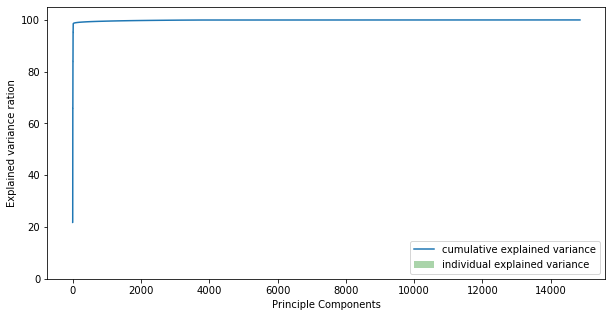

In [61]:
plt.figure(figsize= (10,5))
plt.bar(range(14859), var_exp, alpha=0.3333, align='center', label='individual explained variance', color='g')
plt.step(range(14859), cum_var_exp, where='mid', label='cumulative explained variance')
plt.ylabel('Explained variance ration')
plt.xlabel('Principle Components')
plt.legend(loc='best')
plt.show()

In [72]:
x_7d.shape, X_clustered.shape

((4560, 16), (4560,))

/home/yiyi/anaconda3/envs/semantik/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/home/yiyi/anaconda3/envs/semantik/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/yiyi/anaconda3/envs/semantik/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


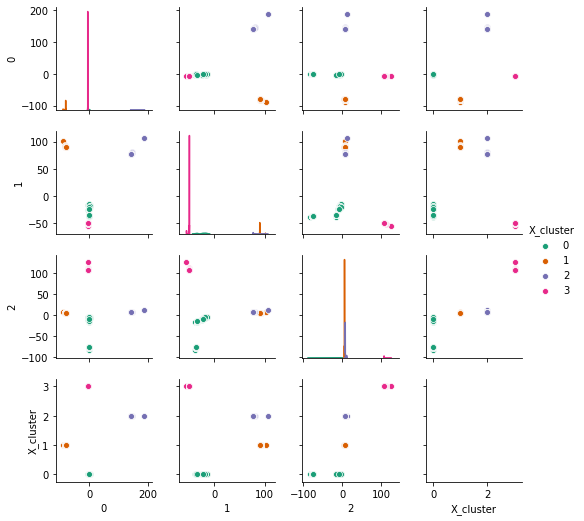

In [52]:
# Create a temp dataframe from our PCA projection data "x_9d"
df = pd.DataFrame(x_7d)
df = df[[0,1,2]] # only want to visualise relationships between first 3 projections
df['X_cluster'] = X_clustered

# Call Seaborn's pairplot to visualize our KMeans clustering on the PCA projected data
sns.pairplot(df, hue='X_cluster', palette= 'Dark2', diag_kind='kde',size=1.85)

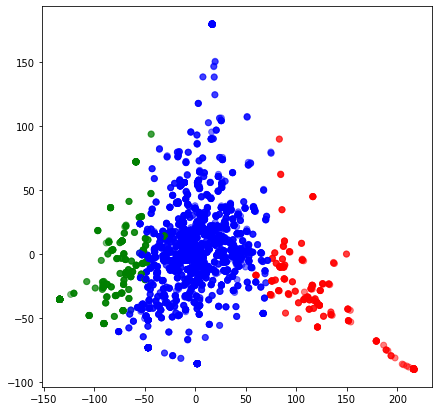

In [47]:
#Set a 3 KMeans clustering
kmeans = KMeans(n_clusters = 3)

#Compute cluster centers and predict cluster indices
X_clustered = kmeans.fit_predict(x_4d)

#Define our own color map
LABEL_COLOR_MAP = {0:'r', 1: 'g', 2: 'b'}
label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]

# Plot the scatter digram
plt.figure(figsize = (7,7))
plt.scatter(x_4d[:,0],x_4d[:,2], c= label_color, alpha=0.5) 
plt.show()


In [48]:
# Create a temp dataframe from our PCA projection data "x_9d"
df = pd.DataFrame(x_4d)
df = df[[0,1,2]] # only want to visualise relationships between first 3 projections
df['X_cluster'] = X_clustered

/home/yiyi/anaconda3/envs/semantik/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/home/yiyi/anaconda3/envs/semantik/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/yiyi/anaconda3/envs/semantik/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


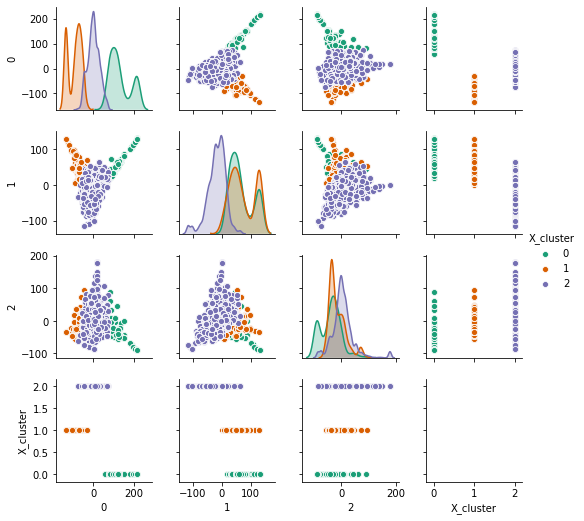

In [50]:
# Call Seaborn's pairplot to visualize our KMeans clustering on the PCA projected data
sns.pairplot(df, hue='X_cluster', palette= 'Dark2', diag_kind='kde',size=1.85)

## no-typed data

In [59]:
features_df_pred = pd.DataFrame(features_pred)
features_df_pred = features_df_pred.rename(columns= id2args)
features_df_pred = features_df_pred.rename(index= id2label_pred)
features_df_pred.head()

,"(boc tower, hong kong)","(chaplin, chaplin)","(walter gropius, bauhaus)","(hawaii state supreme court, ali ʻ iōlani hale)","(thurgot, saint andrews)","(santiniketan, indian)","(goldwater, reagan)","(dostum, rabbani)","(coloman, béla)","(rockies, oakland athletics)",...,"(bali strait, java)","(brown, sarah macaulay)","(statenvertaling, dutch)","(sagan, aaas 's)","(spain, coimbra)","(france, cascade mountains)","(love, brian wilson)","(lenin, reds)","(kelly, daisy bell)","(mclean, lisa kindred)"
star,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
be,1,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
appoint,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
established,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
carry,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
features_df.where(features_df>1)

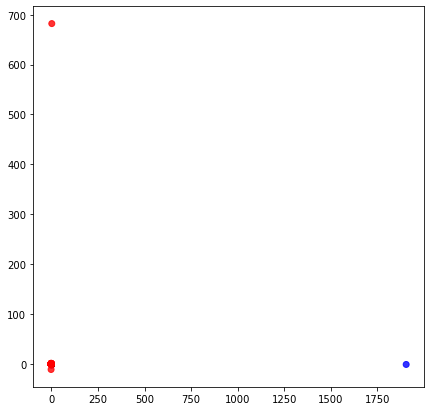

In [43]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

X_pred = StandardScaler().fit_transform(features_pred)


pca4 = PCA(n_components=4)
x_4d = pca4.fit_transform(X_pred)

#Set a 3 KMeans clustering
kmeans_pred = KMeans(n_clusters = 3)

#Compute cluster centers and predict cluster indices
X_clustered = kmeans_pred.fit_predict(x_4d)

#Define our own color map
LABEL_COLOR_MAP = {0:'r', 1: 'b', 2: 'purple'}
label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]

# Plot the scatter digram
plt.figure(figsize = (7,7))
plt.scatter(x_4d[:,0],x_4d[:,2], c= label_color, alpha=0.8) 
plt.show()


In [48]:
X_pred = StandardScaler().fit_transform(features_pred)

pca4 = PCA(n_components=1)
x_4d = pca4.fit_transform(X_pred)

X_pred = StandardScaler().fit_transform(features_pred)
#Set a 3 KMeans clustering
kmeans = KMeans(n_clusters = 3)

X_clustered= kmeans.fit(x_4d)
cluster_map = pd.DataFrame()
cluster_map['data_index']=features_df_pred.index.values
cluster_map['cluster']=X_clustered.labels_

In [70]:
cluster_map.shape

(1418, 2)

In [50]:
for i in range(0, 3):
    print(cluster_map[cluster_map.cluster==i])

        data_index  cluster
0             star        0
3      established        0
4            carry        0
5             give        0
7          express        0
10            play        0
13            beat        0
14           clash        0
15       establish        0
16           leave        0
17            snub        0
18            bury        0
19     incorporate        0
20          employ        0
22           write        0
23           serve        0
24            bear        0
25       introduce        0
26         condemn        0
27          oppose        0
28          repeal        0
29         deliver        0
31           offer        0
32            sink        0
33        separate        0
35           cause        0
39        continue        0
40       recommend        0
42         feature        0
43      contribute        0
...            ...      ...
1388    trailblaze        0
1389         judge        0
1390        pepper        0
1391          land  

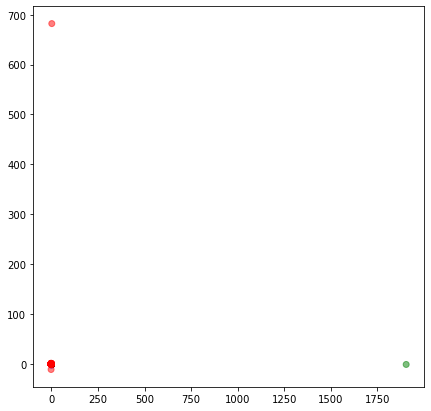

In [64]:

#Set a 3 KMeans clustering
kmeans = KMeans(n_clusters = 3)

#Compute cluster centers and predict cluster indices
X_clustered = kmeans.fit_predict(x_4d)

#Define our own color map
LABEL_COLOR_MAP = {0:'r', 1: 'g', 2: 'b'}
label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]

# Plot the scatter digram
plt.figure(figsize = (7,7))
plt.scatter(x_4d[:,0],x_4d[:,2], c= label_color, alpha=0.5) 
plt.show()


In [57]:


# Create a temp dataframe from our PCA projection data "x_9d"
df = pd.DataFrame(x_4d)
df = df[[0,1,2]] # only want to visualise relationships between first 3 projections
df['X_cluster'] = X_clustered


/home/yiyi/anaconda3/envs/semantik/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/home/yiyi/anaconda3/envs/semantik/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/yiyi/anaconda3/envs/semantik/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yiyi/anaconda3/envs/semantik/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/yiyi/anaconda3/envs/semantik/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


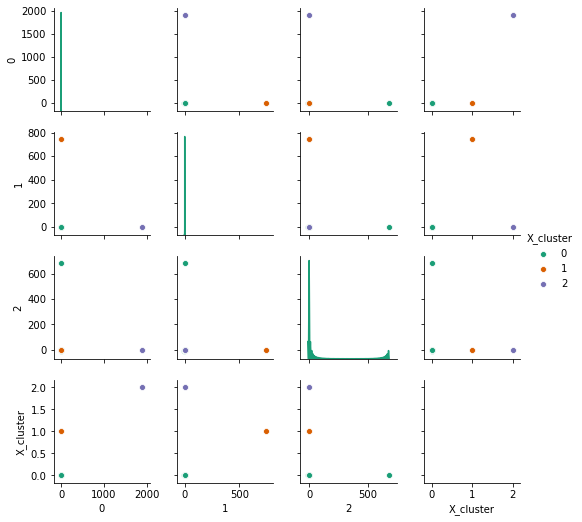

In [58]:
# Call Seaborn's pairplot to visualize our KMeans clustering on the PCA projected data
sns.pairplot(df, hue='X_cluster', palette= 'Dark2', diag_kind='kde',size=1.85)


# toy demo

In [23]:
lists=[[10.63,20.63,10.63,0,0.27],[0.25,0.25,0.25,10.12,0.63],[0.25,0.25,0.25,0.12,5.63]]
darray= np.asarray(lists)
df = pd.DataFrame(darray)
# df
# df = df.rename(index=)
args= [ ("Shakespeare", "Macbeth") , ("Dickens", "Oliver Twist") , ("Rowling", "Harry Potter") , ("Council", "Dublin"), ("Sharon", "Ronnie")]
deargs={idx:args for idx, args in enumerate(args)}
df=df.rename(columns=deargs)
df=df.rename(index= {0:"write_{arg0:PER,arg1:Book}",1:"suggest_{arg0:ORG, arg1:LOC}",2:"suggest_{arg0:PER, arg1:PER}"})

df

,"(Shakespeare, Macbeth)","(Dickens, Oliver Twist)","(Rowling, Harry Potter)","(Council, Dublin)","(Sharon, Ronnie)"
"write_{arg0:PER,arg1:Book}",10.63,20.63,10.63,0.00,0.27
"suggest_{arg0:ORG, arg1:LOC}",0.25,0.25,0.25,10.12,0.63
"suggest_{arg0:PER, arg1:PER}",0.25,0.25,0.25,0.12,5.63
